In [7]:
# Try to load netket, and install it if the import fails
import netket as nk

import netket as nk
import numpy as np
import matplotlib.pyplot as plt

(mc_convergence)=
# Checking Monte Carlo convergence

In Variational Monte Carlo the expectation values we compute are stochastic estimates that rely on the Markov chains being **well-mixed** and **thermalized**.
When this is not the case, every quantity you compute — energies, gradients, observables — is unreliable, and your optimization may be solving the wrong problem.

However, it is customary in NQS training on GPUs to work with very short chains on which it is challenging to reliably estimate whether they are well mixed during training. 
In practice, if you tune it well this gives great speedups and does not hamper convergence, but **you are travelling blindly and can't know easily if MC is an issue or not**. 

NetKet provides two methods on {class}`~netket.vqs.MCState` that help you diagnose and control sampling quality, which we will discuss in this page.

| Method | Purpose |
|---|---|
| {meth}`~netket.vqs.MCState.check_mc_convergence` | Diagnose chain mixing quality for a given operator |
| {meth}`~netket.vqs.MCState.expect_to_precision` | Sample until a target statistical error is reached |

This guide explains when and how to use these tools.

:::{warning}
Both methods are **experimental** and subject to change without notice in future NetKet releases.
If you find them useful (or not!), please let us know with a 👍 / 👎 on [GitHub](https://github.com/netket/netket) or on [Slack](https://netket.readthedocs.io/en/latest/community.html).
:::

## The chain-length problem in VMC

At every VMC iteration, the sampler runs several Markov chains of length `chain_length` to generate samples used to estimate the energy and its gradient.
Reliable sampling diagnostics — the Gelman-Rubin $\hat{R}$ statistic and the integrated autocorrelation time $\tau_\text{corr}$ — require chains of at least **~100 steps** to be meaningful.

However, in practice, the chain length per iteration is often very short — typically **2 to 8 steps per chain** — because:

- Modern GPUs are efficient at running thousands of **parallel chains** simultaneously, so you amortise the fixed overhead over many chains rather than making each chain longer.
- Each parameter update changes the wavefunction, so there is little benefit in running very long chains before updating.
- During the optimization the wavefunction changes little step-to-step, so you effectively thermalise across small changes of parameters.

A typical setup might look like:

In [3]:
L = 20
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=1 / 2, N=g.n_nodes)
ha = nk.operator.Ising(hilbert=hi, graph=g, h=1.0)
ma = nk.models.RBM(alpha=1, param_dtype=float)

# Many parallel chains (512), but each chain is only 2 steps long per iteration
# (1008 samples / 512 chains ≈ 2 steps/chain/iteration)
sa = nk.sampler.MetropolisLocal(hi, n_chains=512, sweep_size=L)
vs = nk.vqs.MCState(sa, ma, n_samples=1024, n_discard_per_chain=10)

print(f"Number of chains    : {vs.sampler.n_chains}")
print(f"Steps per chain     : {vs.chain_length}")
print(f"Total samples       : {vs.n_samples}")

Number of chains    : 512
Steps per chain     : 2
Total samples       : 1024


With `chain_length = 2`, the $\hat{R}$ and $\tau_\text{corr}$ estimates printed by `vs.expect()` at each step are **unreliable** — not enough data per chain to compute them.
Despite this, the optimization can still converge, because the *average* over many short chains is still statistically valid (the bias is controlled by the parameter changes between steps, not by chain length).

Let us run a short VMC optimisation and look at what is logged:

In [4]:
import optax

op = optax.sgd(learning_rate=0.02)
gs = nk.driver.VMC_SR(
    ha,
    op,
    variational_state=vs,
    diag_shift=0.01,
)

log = nk.logging.RuntimeLog()
gs.run(n_iter=300, out=log)

Automatic SR implementation choice:  QGT
online_statistics: chain_length=2, decay=0.960


  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['Energy', 'acceptance', 'Energy_ema'],)

## The `Energy_ema` diagnostic during optimization

When the chain length is short (less than ~50 steps), {class}`~netket.driver.VMC_SR` automatically accumulates local-energy samples across iterations using an **exponential moving average (EMA)** window.
This effectively pools samples from multiple consecutive iterations to build a longer virtual chain, making $\hat{R}$ and $\tau_\text{corr}$ estimates meaningful even when each individual iteration has a very short chain.

The resulting running statistics are logged as `Energy_ema` alongside the usual `Energy` key:

:::{warning}
The autocorrelation time so computed is not the standard autocorrelation time because the chain is not stationary! Similarly, the ``R_hat`` is also different from what Gellman had envisaged. 

Those quantities are still meaningful most of the time, but they may break in some instances. Be a bit cautious, and if you think they are giving wrong hints, let us know.

:::

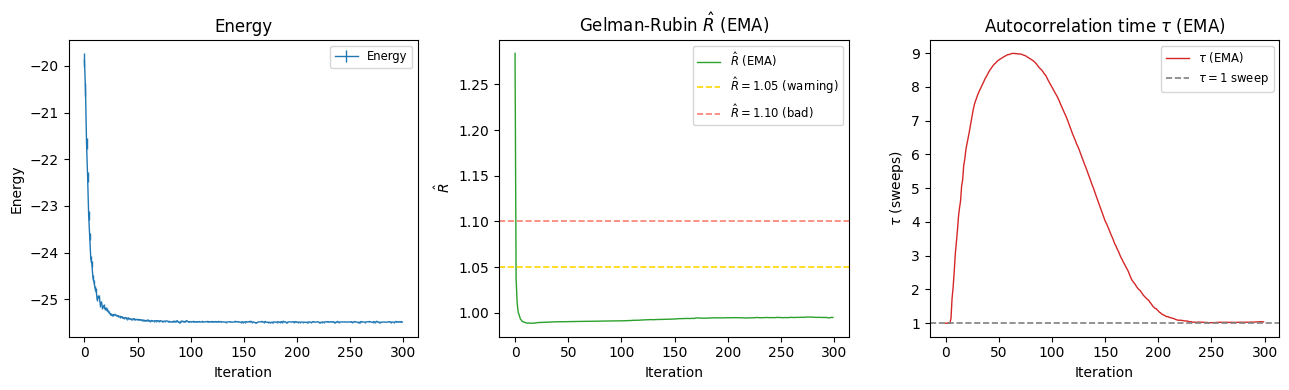

In [5]:
iters = log.data["Energy"].iters
energy_mean = np.real(log.data["Energy"].Mean)
energy_err  = np.real(log.data["Energy"].Sigma)

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Energy convergence
ax = axes[0]
ax.errorbar(iters, energy_mean, yerr=energy_err, fmt="-", lw=1, capsize=0, label="Energy")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
ax.set_title("Energy")
ax.legend(fontsize="small")

# R-hat from EMA
ax = axes[1]
rhat_ema = np.real(log.data["Energy_ema"].R_hat)
ax.plot(log.data["Energy_ema"].iters, rhat_ema, lw=1, color="C2", label=r"$\hat{R}$ (EMA)")
ax.axhline(1.05, color="gold",  lw=1.2, ls="--", label=r"$\hat{R}=1.05$ (warning)")
ax.axhline(1.10, color="salmon", lw=1.2, ls="--", label=r"$\hat{R}=1.10$ (bad)")
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$\hat{R}$")
ax.set_title(r"Gelman-Rubin $\hat{R}$ (EMA)")
ax.legend(fontsize="small")

# tau from EMA (key in the log is "TauCorr")
ax = axes[2]
tau_ema = np.real(log.data["Energy_ema"].TauCorr)
ax.plot(log.data["Energy_ema"].iters, tau_ema, lw=1, color="C3", label=r"$\tau$ (EMA)")
ax.axhline(1.0, color="gray", lw=1.2, ls="--", label=r"$\tau = 1$ sweep")
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$\tau$ (sweeps)")
ax.set_title(r"Autocorrelation time $\tau$ (EMA)")
ax.legend(fontsize="small")

fig.tight_layout()
plt.show()

The `Energy_ema` statistics give you a live sampling health-check during optimization:

- **$\hat{R} \lesssim 1.05$** — chains are well-mixed: good.
- **$\hat{R} > 1.1$** — chains are not mixing: consider increasing `sweep_size` or `n_discard_per_chain`.
- **$\tau_\text{corr} < 1$ sweep** — consecutive samples are effectively independent: good.
- **$\tau_\text{corr} > 1$ sweep** — samples are correlated; consider increasing `sweep_size`.

:::{note}
The EMA window averages across consecutive optimization steps, so it can mix information from slightly different wavefunctions.
For a more reliable diagnosis on the **final converged state**, use {meth}`~netket.vqs.MCState.check_mc_convergence` as described below.
:::

## Post-optimization check: `check_mc_convergence`

After optimization has converged, you should verify that the **final variational state** samples well.
The method {meth}`~netket.vqs.MCState.check_mc_convergence` does this by:

1. Working on a temporary copy of the state (the original is never mutated).
2. Resetting the internal sweep size to 1, so every elementary MC step is an individual sample — this exposes short-range correlations.
3. Accumulating batches of local estimators and feeding them into an online statistics engine that tracks mean, variance, $\hat{R}$, and the integrated autocorrelation time $\tau_\text{corr}$ via Geyer's *initial positive sequence* (IPS) estimator.
4. Adaptively doubling the sweep size if the autocorrelation window saturates (i.e., the chains are still strongly correlated at the maximum lag).
5. Stopping when the $\tau_\text{corr}$ estimate is reliable — roughly when there are at least **50 effective samples per chain**.

The function requires chains of at least **~100 steps** to reliably estimate $\hat{R}$ and $\tau_\text{corr}$.  This is perfectly fine when called post-optimization, since we are no longer constrained by the per-iteration speed budget.

Let's run it now on the converged state:

MC convergence:   0%|          | 2/500 [00:00<?, ? spl/chain/s]

  Reached maximum chain length (500 samples/chain). Stopping.

---- MC Convergence Results ----
  Final statistics         : -25.48661 ± 0.00054 [σ²=2.7e-02, R̂=1.002]

  τ_corr (MC steps)        : 2.35

  MCState.sweep_size       : 20
  τ_corr (MC sweeps)       : 0.118  ✅  (< 1 sweep — good)

  Minimum sweep_size       : ~4.7  (= 2 × τ_corr in MC steps)

  In NQS, keep sweep_size ≥ 2τ (MC steps) so that consecutive samples
  are effectively independent and all samples carry useful information.
--------------------------------


/Users/filippo.vicentini/Nextcloud/Codes/Python/netket/netket/_src/vqs/plot_mc_convergence.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


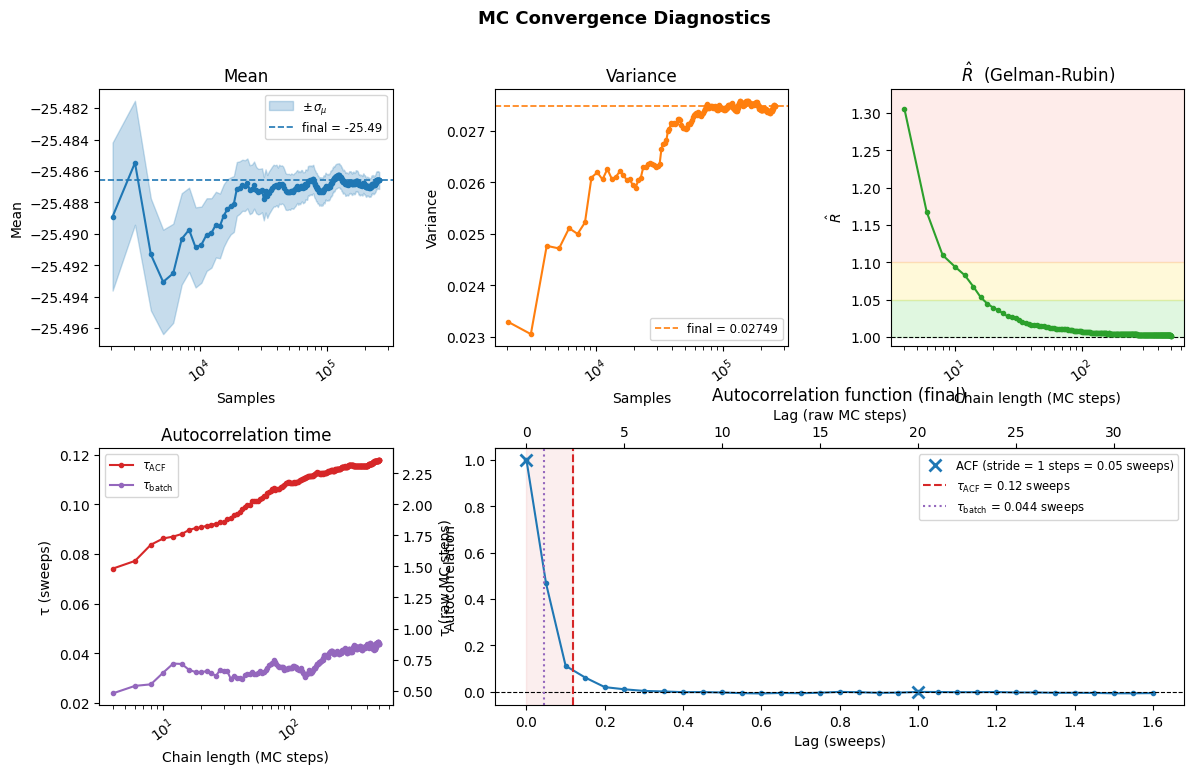

In [6]:
# check_mc_convergence works on a copy of vs — it does not modify vs
stats, hist = vs.check_mc_convergence(ha, min_chain_length=500, plot=True)

Notice that everything computed and reported here is relative to the operator we provided to the function, in this case to the energy. Different operators might expose different MC convergence issues!
The figure produced by `plot=True` has five panels:

 - **Mean:** Should stabilise as more samples are accumulated. 
 - **Variance:**  Should stabilise similarly. 
 - **$\hat{R}$:** (Gelman-Rubin) | Should approach 1.  Values $< 1.05$ (green band) are good; $> 1.1$ (red) indicates poor mixing. You should see that for short chains ($<20$ in this example) the Gelman-Rubin R estimator is overestimated and unreliable. That motivates the online estimation discussed above. 
 - **$\tau_\text{corr}$:**  Correlation time in sweep units.  Values $< 1$ mean consecutive samples are effectively independent — good. We report two esitmates of the autocorrelation time, one due to Gellman and Rubin based on the variance among chains, which is at most 1/2 of the real autocorrelation time computed by convolving the data across small windows.
 - **Autocorrelation function:**  Should decay to zero within the lag window. A shaded region highlights $\tau_\text{ACF}$. 

We report the autocorrelation time and function both in units of the sweeps, as well as in units of the raw MC steps. Consider that a sweep is `sampler.sweep_size` MC steps. 
In general you want your sweep size to be larger than 2x the autocorrelation time AT THE LEAST otherwise you are effectivelly wasting compute time.

This function also tells you:

- The correlation time in raw MC steps.
- Whether your current `sweep_size` is large enough.
- The recommended minimum `sweep_size` (= $2\tau_\text{MC}$ raw steps).

A healthy output looks like:
```python
  τ_corr (MC sweeps)       : 0.3  ✅  (< 1 sweep — good)
```
whereas a problematic one reads:
```python
  τ_corr (MC sweeps)       : 2.1  ❌  (≥ 1 sweep — consider increasing sweep_size)
```

## High-precision estimation: `expect_to_precision`

Once you are satisfied that the chains are mixing well, you may want to compute an observable to a specific **statistical precision**.
Simply running `vs.expect(op)` with a fixed number of samples gives you whatever error the current `n_samples` yields.
With {meth}`~netket.vqs.MCState.expect_to_precision` you instead specify the desired error and let NetKet sample until that precision is reached.

The method accepts:

- `atol` — desired **absolute** standard error on the mean.
- `rtol` — desired **relative** standard error (i.e. `error / |mean|`).
- Both can be given simultaneously; sampling continues until *both* are satisfied.

It works by iteratively drawing new batches of samples and updating an online statistics accumulator, showing a progress bar as it goes.

Let us compute the staggered magnetisation $M_z = \frac{1}{L}\sum_i (-1)^i \hat{\sigma}^z_i$ to a 1% relative precision:

In [ ]:
# Staggered magnetisation
mag = sum((-1)**i * nk.operator.spin.sigmaz(hi, i) for i in range(L)) / L

# Sample until |error / mean| <= 1 %
online_stats = vs.expect_to_precision(mag, rtol=0.01)

# Get the final Stats object
result = online_stats.get_stats()
print(result)

The returned {class}`~netket.stats.OnlineStatistics` accumulator can also give you $\hat{R}$ and $\tau_\text{corr}$ at the end of the sampling:

In [ ]:
print(f"Mean              : {result.mean:.6f}")
print(f"Error of mean     : {result.error_of_mean:.2e}")
print(f"R-hat             : {online_stats.R_hat:.5f}")
print(f"tau_corr (ACF)    : {online_stats.tau_corr_acf:.3g} sweeps")

## Summary and practical advice

The table below summarises when to use each tool:

| Situation | Tool | Notes |
|---|---|---|
| During optimization, chains are short (2–8 steps) | `Energy_ema` in {class}`~netket.driver.VMC_SR` log | Proxy diagnostics from pooled samples across iterations |
| After optimization, verify final state quality | {meth}`~netket.vqs.MCState.check_mc_convergence` | Needs long chains (~100–500 steps); works on a copy |
| Need a precise expectation value with known error | {meth}`~netket.vqs.MCState.expect_to_precision` | Samples until `atol`/`rtol` is met |

Regarding Rhat, the mixing indicator:

| Diagnostic | Healthy | Warning | Bad |
|---|---|---|---|
| $\hat{R}$ | $< 1.05$ | $1.05$–$1.1$ | $> 1.1$ |
| $\tau_\text{corr}$ (sweeps) | $< 1$ | — | $\geq 1$ |
### If diagnostics are bad

If $\hat{R}$ is large, you need to:
- **Thermalise your chains** in some way
- **Switch to a better transition rule** — e.g., {class}`~netket.sampler.rules.HamiltonianRule` explores the Hilbert space more effectively than {class}`~netket.sampler.rules.LocalRule` for some problems.
- **Check your model** — very high-variance models can make the energy landscape rugged and slow down mixing.

If $\tau_\text{corr}$ exceeds one sweep, try one or more of the following:

- **Increase `sweep_size`** — the recommended minimum is $2\tau_\text{MC}$ raw steps, as reported by `check_mc_convergence`.
- **Increase `n_discard_per_chain`** — discard more steps at the start of each chain to reduce the effect of the initial state.

:::{seealso}
- {meth}`netket.vqs.MCState.check_mc_convergence` — full API reference.
- {meth}`netket.vqs.MCState.expect_to_precision` — full API reference.
- {ref}`Sampler user guide <Sampler>` — how to construct and tune samplers.
:::